In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# **Mô tả bài toán**
**Input**: Dữ liệu dạng text câu hỏi

**Output**: Phân loại các câu insincere và sincere có trên hệ thống của Quora

# **Phân tích dữ liệu**


In [ ]:
data_train = pd.read_csv("../input/quora-insincere-questions-classification/train.csv")
data_test = pd.read_csv("../input/quora-insincere-questions-classification/test.csv")

Tập dữ liệu train gồm 3 trường, trong đó:
* **qid**: mã câu hỏi
* **question_text**: nội dung câu hỏi
* **target**: gồm hai giá trị "insincere" mang giá trị là 1 còn "sincere" là 0

In [ ]:
data_train

Tập dữ liệu test gồm hơn 300 nghìn dòng

In [ ]:
data_test

**Tính cân bằng của tập dữ liệu**

Ta xét tỷ lệ câu sincere và insincere trong tập dữ liệu train

In [ ]:
# Mô phỏng về độ tương quan giữa các câu insincere và sincere dưới dạng biểu đồ:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='target', data=data_train)
total = data_train.shape[0]
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 3, '{0:.0%}'.format(height/total), ha="center")
plt.suptitle('Number of Sincere and Insincere Questions')
plt.show()

Ta thấy tỷ lệ giữa 2 loại câu hỏi khoảng 15:1. Đây là hiện tượng mất cân bằng nghiêm trọng dẫn tới kết quả dự báo kém chính xác trên nhóm thiểu số.

**Xử lý mất cân bằng dữ liệu**

Khi một bên chiếm đa số và bên còn lại thiểu số, hiển nhiên sẽ có 2 cách để làm cân bằng chúng:
* Tăng số lượng bên thiểu số (Over sampling): thu thập thêm dữ liệu hoặc chấp nhận mẫu có trùng lặp.
* Giảm số lượng bên đa số (Under sampling): cân bằng mẫu một cách nhanh chóng, dễ dàng tiến hành thực hiện nhưng kích thước mẫu sẽ giảm đáng kể.

Ta sử dụng phương pháp **Under sampling**: giảm bớt sự mất cân bằng (1:4) sao cho không ảnh hưởng đáng kể tới khả năng dự báo của mô hình.

In [ ]:
from sklearn.utils import resample

sincere = data_train[data_train.target == 0]
insincere = data_train[data_train.target == 1]
data_train_sampled = pd.concat([resample(sincere, replace = True, n_samples = len(insincere)*4), insincere])
data_train_sampled

In [ ]:
y = data_train_sampled['target']
y.value_counts().plot(kind='bar', rot=0)

# **Mô tả thuật toán**
## **1.Tiền xử lý dữ liệu**
Bước đầu tiên ta phải loại bỏ những tác nhân gây nhiễu hoặc không cần thiết, có thể gây ảnh hưởng đến kết quả:
* Loại bỏ các tag HTML
* Loại bỏ các dấu nháy đơn, nháy kép
* Loại bỏ các số thực, số phức
* Loại bỏ các kí tự La Mã
* Thay thế các dấu, các kí tự đặc biệt với khoảng trắng
* Đưa tất cả các chữ cái viết hoa, viết thường về dạng chung là viết thường

In [ ]:
import re, string

def clean_text(text):

  # Remove HTML Tags
  text = re.sub(re.compile('<.*?>'), '', text)

  # Remove [\], ['], ["]
  text = re.sub(r'\\', '', text)
  text = re.sub(r'\"', '', text)
  text = re.sub(r'\'', '', text)

  # Remove number
  text = re.sub('[0-9]{5,}','#####', text);
  text = re.sub('[0-9]{4,}','####', text);
  text = re.sub('[0-9]{3,}','###', text);
  text = re.sub('[0-9]{2,}','##', text);

  ## Remove Roman words
  roman = re.compile(r'^M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})$');
  text = roman.sub(r'', text);

  # Convert all text to lowercase
  text = text.strip().lower()

  # Replace punctuation chars with spaces
  filters = '!"\'#$%@&*()+_-;:<=>.?{}|`\\^\t\n'
  translate_dict = dict((c, " ") for c in filters)
  translate_map = str.maketrans(translate_dict)
  text = text.translate(translate_map)

  return text

## **2.Vector hóa dữ liệu**
* Sử dụng CountVectorizer để trích xuất các từ, biến words thành dạng vectors ở dạng Bag-of-Words bằng cách đếm số lần xuất hiện của các từ trong bộ dữ liệu.
* TF-IDF (Term Frequency – Inverse Document Frequency) là 1 kĩ thuật sử dụng trong khai phá dữ liệu văn bản. Trọng số này được sử dụng để đánh giá tầm quan trọng của một từ trong một văn bản. Giá trị cao thể hiện độ quan trọng cao và nó phụ thuộc vào số lần từ xuất hiện trong văn bản nhưng bù lại bởi tần suất của từ đó trong tập dữ liệu.

Ta chuyển đổi dữ liệu từ text sang thể hiện vector thông qua TfidfVectorizer.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words="english",
                             preprocessor=clean_text,
                             ngram_range=(1, 3))
X = vectorizer.fit_transform(data_train_sampled['question_text'])
x = vectorizer.transform(data_test['question_text'])

Sau khi chuyển đổi tập dữ liệu text thành các vector, các biểu diễn dạng số, ta phân chia bộ dữ liệu thành tập train (dùng để huấn luyện mô hình) và tập test (dùng để kiểm tra mô hình được huấn luyện) theo tỉ lệ 80%, 20%

In [ ]:
# Chia dataset thành các tập train và test theo tỉ lệ 80%, 20%
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, data_train_sampled['target'], test_size=0.2, random_state=42)

Do ta đang làm việc trên dataset thiếu cân bằng => sử dụng đại lượng **F1-score** trung bình điều hòa giữa precision (độ chính xác) và recall (độ bao phủ)

F1-score được biểu diễn như sau:

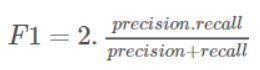

Cách tính F1-score sử dụng sklearn:

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, classification_report
# Tính f1-score
def get_f1(model, name):
  y_train_pred, y_pred = model.predict(X_train), model.predict(X_test)
  print(classification_report(y_test, y_pred), '\n')

  print('{} model with F1 score = {}'.format(name, f1_score(y_test, y_pred)))

# **Huấn luyện mô hình**


In [ ]:
import xgboost as xgb
xgb = xgb.XGBClassifier()
xgb.fit(X_train, y_train)

In [ ]:
get_f1(xgb, 'XGBClassifier')

# **Submition**

In [ ]:
model = xgb
submission = pd.read_csv('/kaggle/input/quora-insincere-questions-classification/sample_submission.csv')
preds = model.predict(x)
submission.loc[:, 'prediction'] = preds
submission

In [ ]:
submission.to_csv('submission.csv', index=False)